<h1> Human Activity Recognition Using Smartphones Data Set </h1>

<ol>
    <li> 
    <b>
        Abstract: 
    </b> 
    Human Activity Recognition database built from the recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors.
    </li> <br>
    <li> 
    <b>
        Data Set Information: 
    </b>
        <ul> 
            <li>
    The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.         
        </li> 
            <br>
        <li>
            The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.
            </li>
        </ul>
</ol>

Link to source : https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

<h3> Importing Libraries .... </h3>

In [42]:
import os
import zipfile
import pandas as pd
import numpy as np
import requests
import io
# To create plots
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import seaborn as sns

# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.express as px
init_notebook_mode(connected=True)

# for models
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM ,Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
r = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("Datasets")

In [2]:
train_path = "Datasets/UCI HAR Dataset/train/"
test_path = "Datasets/UCI HAR Dataset/test/"
features_path = "Datasets/UCI HAR Dataset/features.txt"
# path = 'Datasets/UCI HAR Dataset'

In [3]:
features = []
with open(features_path) as f:
    features = [line.split()[1] for line in f.readlines()]
print('Total No of Features: {}'.format(len(features)))
print("Total No. of unique features:{}".format(len(set(features))))

Total No of Features: 561
Total No. of unique features:477


In [4]:
labels = {
              1: 'WALKING', 
              2:'WALKING_UPSTAIRS',
              3:'WALKING_DOWNSTAIRS',
              4:'SITTING',
              5:'STANDING',
              6:'LAYING'
          }
signals = [
                "body_acc_x",
                "body_acc_y",
                "body_acc_z",
                "body_gyro_x",
                "body_gyro_y",
                "body_gyro_z",
                "total_acc_x",
                "total_acc_y",
                "total_acc_z"
          ]

In [5]:
replace=[]
for i , f in enumerate(features):
    for j in range(i+1 , len(features)):
        if features[i]==features[j] and features[i] not in replace:
            replace.append(features[i])

In [6]:
for i , y in enumerate(features):
    features[i] = ''.join(x for x in y if x not in ['(',')' , '-' , ',']) 

In [7]:
training_data = pd.read_csv(train_path + "X_train.txt" , delim_whitespace=True ,header=None, low_memory=False)
training_data.columns = features
training_data['subject'] = pd.read_csv(train_path + 'subject_train.txt' , header=None , squeeze=True, low_memory=False)

testing_data = pd.read_csv(test_path + "X_test.txt" , delim_whitespace=True ,header=None, low_memory=False)
testing_data.columns = features
testing_data['subject'] = pd.read_csv(test_path + 'subject_test.txt' , header=None , squeeze=True, low_memory=False)

In [8]:
training_data.head(2)

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,...,fBodyBodyGyroJerkMagskewness,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1


In [9]:
testing_data.head(2)

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,...,fBodyBodyGyroJerkMagskewness,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.330370,-0.705974,0.006462,0.16292,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.121845,-0.594944,-0.083495,0.01750,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2


In [10]:
print('Total number of rows and columns -> ' ,training_data.shape)
print('Total number of rows and columns -> ' ,testing_data.shape)

Total number of rows and columns ->  (7352, 562)
Total number of rows and columns ->  (2947, 562)


<h3> <li> Checking datatype </li> </h3>

In [11]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 562 entries, tBodyAccmeanX to subject
dtypes: float64(561), int64(1)
memory usage: 31.5 MB


In [12]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 562 entries, tBodyAccmeanX to subject
dtypes: float64(561), int64(1)
memory usage: 12.6 MB


In [13]:
y_train = pd.read_csv(train_path + 'y_train.txt' , names=['Activity'] , squeeze=True, low_memory=False)
y_test = pd.read_csv(test_path + 'y_test.txt' , names=['Activity'] , squeeze=True, low_memory=False)

In [14]:
training_data['Activity']= y_train
testing_data['Activity'] = y_test
training_data['ActivityType'] = y_train.map(labels)
testing_data['ActivityType']  = y_test.map(labels)

<h2> Data Cleaning </h2>
<h3><li> Checking for null values in test and train datasets </li></h3>

In [15]:
print('Training set, Null values :',training_data.isnull().values.sum())
print('Testing set, Null values :',testing_data.isnull().values.sum())

Training set, Null values : 0
Testing set, Null values : 0


<h3><li> Checking for duplicated values in test and train datasets </li></h3>

In [16]:
print('Training set, Duplicated values:',training_data.duplicated().values.sum())
print('Testing set, Duplicated values:',testing_data.duplicated().values.sum())

Training set, Duplicated values: 0
Testing set, Duplicated values: 0


<h3><li> Checking for data imbalancement </li></h3>

In [17]:
# Plotting data
# px.pie(train_data,names='Activity',title='Smartphone Activity Distribution')
label_counts = training_data['ActivityType'].groupby(training_data['ActivityType']).size()

n = label_counts.shape[0]
colormap = get_cmap('magma')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

data = go.Bar(y = label_counts.index,
              x = label_counts,
              marker = dict(color = colors), orientation='h')

layout = go.Layout(title = 'Comparison of all 6 activities',
                   yaxis = dict(title = 'Activity'),
                   xaxis = dict(title = 'Size'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

The data that we have is almost well balanced and it's equally distributed.

In [18]:
fig = px.histogram(training_data, x="subject", color="ActivityType", barmode='group', nbins=30)
fig.show()

<li> Features like Standing, Sitting and Laying is not so important </li>
<li> Focus should be move on movements, like Walking </li>

In [19]:
acceleration=[]
for fts in features:
    if fts.find('BodyAcc') != -1 and fts.find('Magmean') !=-1 and fts.find('Freq')==-1:
        acceleration.append(fts)

In [20]:
acceleration

['tBodyAccMagmean',
 'tBodyAccJerkMagmean',
 'fBodyAccMagmean',
 'fBodyBodyAccJerkMagmean']

In [21]:
for f in acceleration:
    
    fig = px.box(training_data, x='ActivityType',y =f, color_discrete_sequence=px.colors.qualitative.Dark24, title = 'Boxplot Distribution' )
    fig.show()

Unable to plot heatmap due to having high dimension data... it gets more difficult to predict certain quantities.

<li> Reduce dimensionality with TSNE </li>


In [22]:
def plotTsne(X,y,perplexity):
    
    X_reduction = TSNE(verbose=2, perplexity=perplexity).fit_transform(X)
    
    print('Creating plot for this t-sne visualization..')
    data={'x':X_reduction[:,0],
          'y':X_reduction[:,1], 'label':y}
    data_red = pd.DataFrame(data)
    
    sns.lmplot(data=data_red, x='x', y='y', hue='label', fit_reg=False, height=10,palette="bright",markers=['^','v','s','o', '1','2'])
    
    plt.title("perplexity : {}".format(perplexity))
    img_name = 'Diagram_{}.png'.format(perplexity)
    plt.savefig(img_name)
    print('\n')
    plt.show()

In [23]:
X = training_data.drop(['ActivityType'],axis=1)
y = training_data['ActivityType']
perplexity=[1,3,7,9]

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.578s...
[t-SNE] Computed neighbors for 7352 samples in 9.618s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.335951
[t-SNE] Computed conditional probabilities in 0.040s
[t-SNE] Iteration 50: error = 129.0605621, gradient norm = 0.0594700 (50 iterations in 1.466s)
[t-SNE] Iteration 100: error = 110.3027878, gradient norm = 0.0351546 (50 iterations in 1.188s)
[t-SNE] Iteration 150: error = 103.7427902, gradient norm =

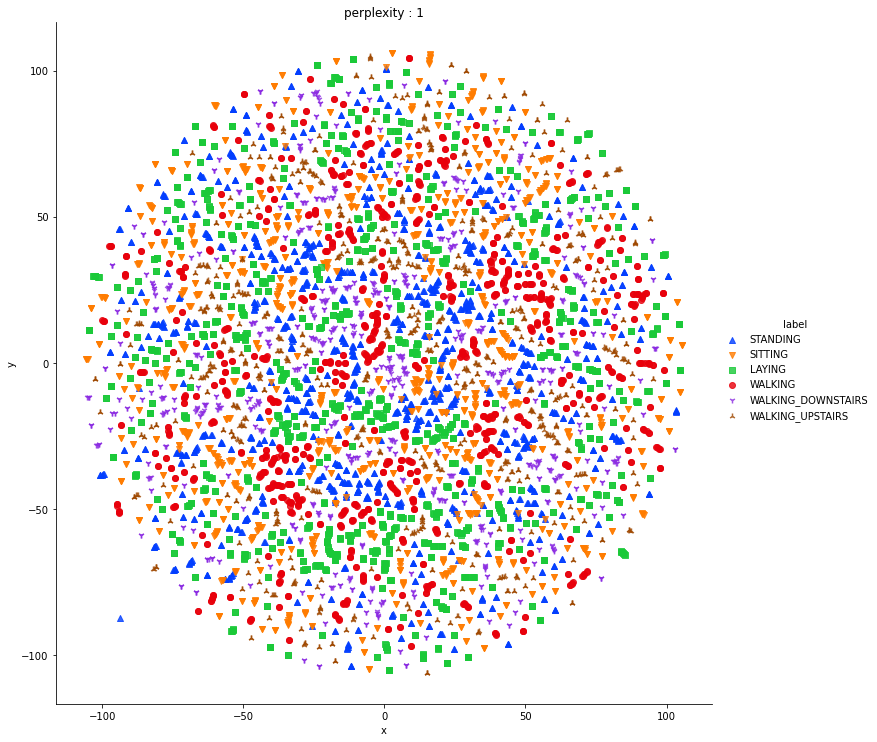

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.524s...
[t-SNE] Computed neighbors for 7352 samples in 10.522s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 0.921922
[t-SNE] Computed conditional probabilities in 0.032s
[t-SNE] Iteration 50: error = 119.7871246, gradient norm = 0.0340148 (50 iterations in 2.178s)
[t-SNE] Iteration 100: error = 99.6679840, gradient norm = 0.0223281 (50 iterations in 1.169s)
[t-SNE] Iteration 150: error = 93.2475128, gradient norm =

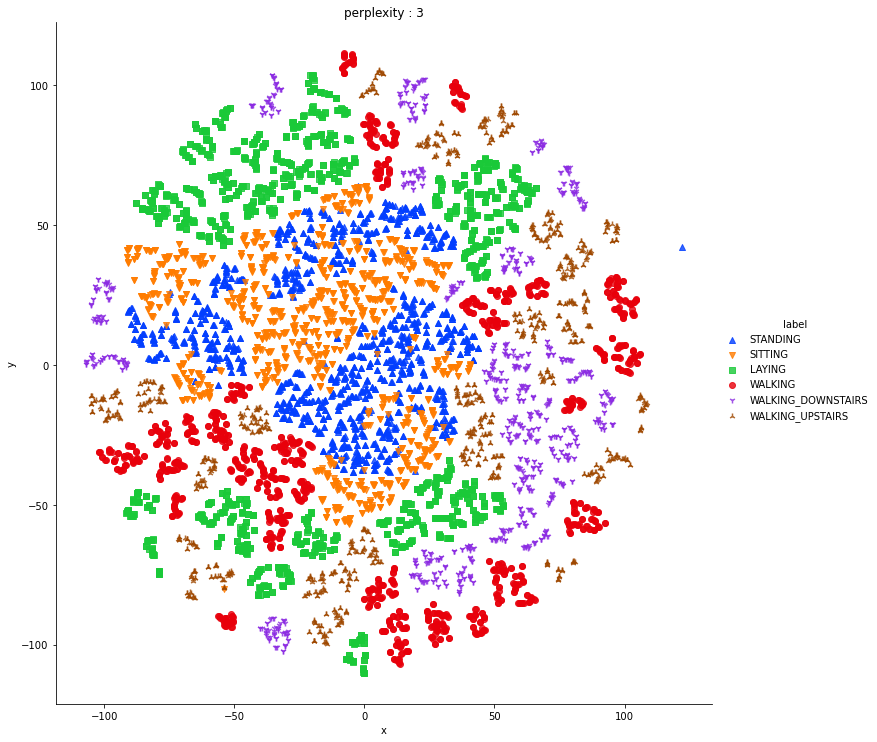

[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.511s...
[t-SNE] Computed neighbors for 7352 samples in 11.444s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.242818
[t-SNE] Computed conditional probabilities in 0.064s
[t-SNE] Iteration 50: error = 108.4660492, gradient norm = 0.0371006 (50 iterations in 1.496s)
[t-SNE] Iteration 100: error = 88.4973450, gradient norm = 0.0170817 (50 iterations in 1.073s)
[t-SNE] Iteration 150: error = 82.9849167, gradient norm =

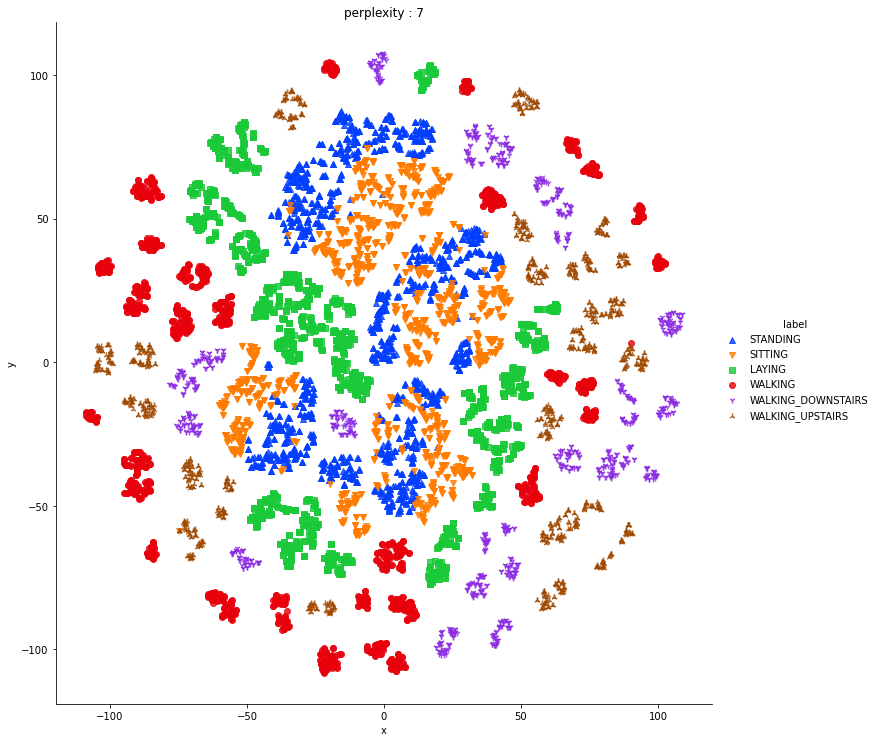

[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 7352 samples in 0.523s...
[t-SNE] Computed neighbors for 7352 samples in 11.752s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7352
[t-SNE] Computed conditional probabilities for sample 2000 / 7352
[t-SNE] Computed conditional probabilities for sample 3000 / 7352
[t-SNE] Computed conditional probabilities for sample 4000 / 7352
[t-SNE] Computed conditional probabilities for sample 5000 / 7352
[t-SNE] Computed conditional probabilities for sample 6000 / 7352
[t-SNE] Computed conditional probabilities for sample 7000 / 7352
[t-SNE] Computed conditional probabilities for sample 7352 / 7352
[t-SNE] Mean sigma: 1.324145
[t-SNE] Computed conditional probabilities in 0.080s
[t-SNE] Iteration 50: error = 104.5831299, gradient norm = 0.0390633 (50 iterations in 1.355s)
[t-SNE] Iteration 100: error = 85.2912750, gradient norm = 0.0144307 (50 iterations in 1.161s)
[t-SNE] Iteration 150: error = 80.0162659, gradient norm =

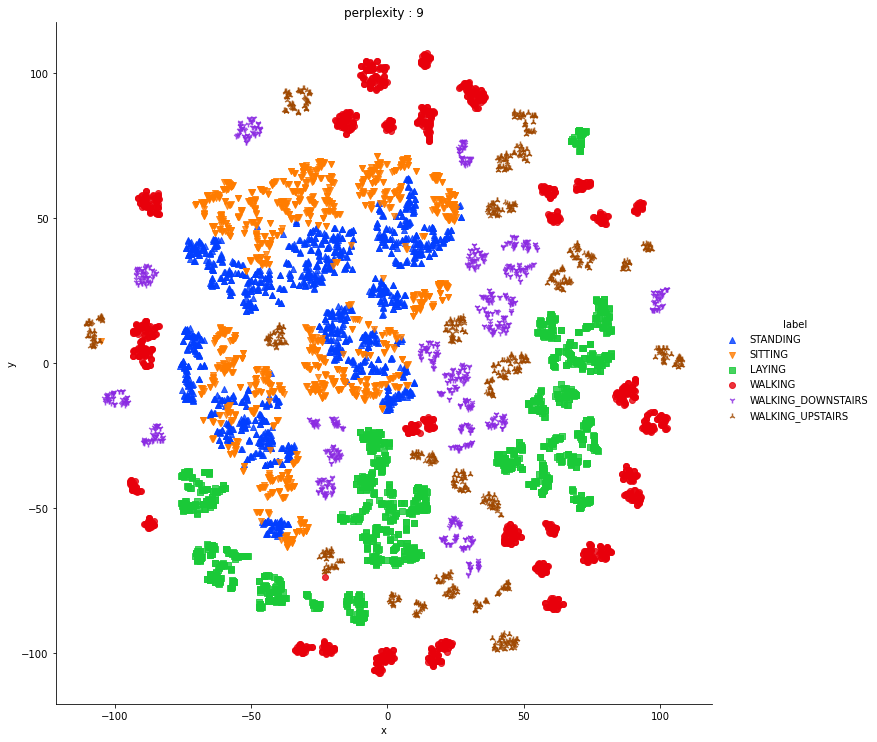

In [24]:
for p in perplexity:
    plotTsne(X,y,perplexity=p)

We can see that all the activities are well distributed but only standing and sitting are unable to separate itself.
Therefore the smartphone is able to detect activities if you are moving around with the smartwatch else it wont be able to detect activities.

<li> MODEL - LSTM </li>

In [44]:

path = 'Datasets/UCI HAR Dataset/'
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []

    for signal in signals:
        filename = path+subset+'/Inertial Signals/'+signal+'_'+subset+'.txt'
        signals_data.append(_read_csv(filename).values) 

    return np.transpose(signals_data, (1, 2, 0))

def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

def load_y(subset):
    filename = path+subset+'/y_'+subset+'.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).values

def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [45]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [46]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [49]:
print('Shape of X_train -> ', X_train.shape)
print('Shape of X_test -> ', X_test.shape)
print('Shape of Y_train -> ', Y_train.shape)
print('Shape of Y_test -> ', Y_test.shape)
n_classes = _count_classes(Y_train)

Shape of X_train ->  (7352, 128, 9)
Shape of X_test ->  (2947, 128, 9)
Shape of Y_train ->  (7352, 6)
Shape of Y_test ->  (2947, 6)


In [50]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(time, dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
              optimizer = 'adam',
              metrics=['accuracy'])

In [69]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Epoch 1/30
460/460 [==============================] - 16s 33ms/step - loss: 0.1715 - accuracy: 0.9376 - val_loss: 0.4306 - val_accuracy: 0.8921
Epoch 2/30
460/460 [==============================] - 17s 37ms/step - loss: 0.1710 - accuracy: 0.9374 - val_loss: 0.3844 - val_accuracy: 0.8985
Epoch 3/30
460/460 [==============================] - 18s 38ms/step - loss: 0.1338 - accuracy: 0.9512 - val_loss: 0.4211 - val_accuracy: 0.9060
Epoch 4/30
460/460 [==============================] - 18s 38ms/step - loss: 0.1232 - accuracy: 0.9476 - val_loss: 0.5170 - val_accuracy: 0.8873
Epoch 5/30
460/460 [==============================] - 16s 34ms/step - loss: 0.3755 - accuracy: 0.8745 - val_loss: 0.4528 - val_accuracy: 0.8738
Epoch 6/30
460/460 [==============================] - 16s 35ms/step - loss: 0.2285 - accuracy: 0.9181 - val_loss: 0.4509 - val_accuracy: 0.8748
Epoch 7/30
460/460 [==============================] - 14s 31ms/step - loss: 0.2825 - accuracy: 0.9117 - val_loss: 0.3544 - val_accuracy:

In [70]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)

In [83]:
print('Training Accuracy : %.3f ' % (train_acc))
print('Test Accuracy : %.3f' % (test_acc))

Training Accuracy : 0.960 
Test Accuracy : 0.907


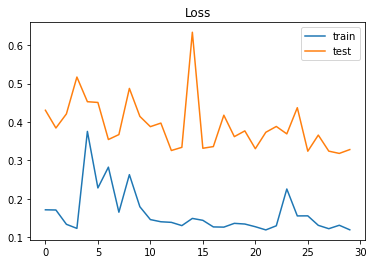

In [84]:
# plot loss during training
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

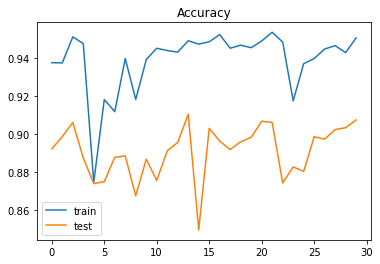

In [85]:
# plot accuracy during training
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()